#ATUHAIRE PAULINE
#ASSIGNMENT 2 DATA LIFE CYCLE
#ACCESS NUMBER:B5093

#CASSAVA YIELD ANALYSIS

In [ ]:
# --- Cell 1: Imports & Load workbook ---
import os
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (6,3.5)

# Load file (path used by the assistant environment)
os.chdir(r'C:\Users\AA\Desktop\DLC ASSIGNMENT2')
file_path = "Cassava_Yield_Data.xlsx"
# print("Loading:", file_path)
df = pd.read_excel(file_path)
print("Shape:", df.shape)
print("Columns:")
print(df.columns.tolist())

# Normalize column names: strip spaces and lowercase a helper map for known variants
df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]
# map likely variants to standard names
col_map = {}
for c in df.columns:
    lc = c.lower().replace(' ', '')
    if lc in ['fertilizer','fertiliser','fertilizers','fert','fertiliserinfo','fertilizersused']:
        col_map[c] = 'fertilizer'
    if lc in ['tillage','tillage_method','tillage_'] or c.lower().strip().startswith('tillage'):
        col_map[c] = 'tillage'
    if lc in ['sesn','season']:
        col_map[c] = 'Sesn'
    if lc in ['totalweightperhectare','totalweightperhectare (kg/ha)'.lower().replace(' ','')]:
        col_map[c] = 'TotalWeightperhectare'
    if lc in ['totaltuberperhectare','totaltuberperhectare (kg/ha)'.lower().replace(' ','')]:
        col_map[c] = 'TotalTuberperHectare'
    if lc in ['plants_harvested','plantsharvested','plants_harvested']:
        col_map[c] = 'Plants_harvested'


for orig in list(df.columns):
    if orig.strip().lower() == 'fert' or orig.strip().lower()=='fertt' or orig.strip().lower()=='fertt':
        col_map[orig] = 'fertilizer'
    if orig.strip().lower() == 'fert' :
        col_map[orig] = 'fertilizer'
    if orig.strip() == 'ferT':
        col_map[orig] = 'fertilizer'
    if orig.strip() == 'tillage ':
        col_map[orig] = 'tillage'

# apply renaming
if col_map:
    print("Applying column renames (sample):", list(col_map.items())[:10])
    df = df.rename(columns=col_map)

# Show the final columns after normalization
print("Normalized columns:")
print(df.columns.tolist())
df.head()

Shape: (115, 20)
Columns:
['Sesn', 'locn', 'block', 'rep', 'tillage ', 'ferT', 'Plants_harvested', 'No_bigtubers', 'Weigh_bigtubers', 'No_mediumtubers', 'Weight_mediumtubers', 'No_smalltubers', 'Weight_smalltubers', 'Totaltuberno', 'AV_tubers_Plant', 'Total_tubweight', 'plotsize', 'HEC', 'TotalWeightperhectare', 'TotalTuberperHectare']
Applying column renames (sample): [('Sesn', 'Sesn'), ('tillage', 'tillage'), ('ferT', 'fertilizer'), ('Plants_harvested', 'Plants_harvested'), ('TotalWeightperhectare', 'TotalWeightperhectare'), ('TotalTuberperHectare', 'TotalTuberperHectare')]
Normalized columns:
['Sesn', 'locn', 'block', 'rep', 'tillage', 'fertilizer', 'Plants_harvested', 'No_bigtubers', 'Weigh_bigtubers', 'No_mediumtubers', 'Weight_mediumtubers', 'No_smalltubers', 'Weight_smalltubers', 'Totaltuberno', 'AV_tubers_Plant', 'Total_tubweight', 'plotsize', 'HEC', 'TotalWeightperhectare', 'TotalTuberperHectare']


,Sesn,locn,block,rep,tillage,fertilizer,Plants_harvested,No_bigtubers,Weigh_bigtubers,No_mediumtubers,Weight_mediumtubers,No_smalltubers,Weight_smalltubers,Totaltuberno,AV_tubers_Plant,Total_tubweight,plotsize,HEC,TotalWeightperhectare,TotalTuberperHectare
0,2,1,1,1,conv,F2150,28,0,0.0,61,2.5,319,4.7,380,13.571429,7.2,5.3,10000,13584.905660,716981.132075
1,2,1,1,1,conv,F1100,28,0,0.0,110,4.6,260,4.0,370,13.214286,8.6,5.3,10000,16226.415094,698113.207547
2,2,1,1,1,conv,F3200,28,2,0.2,115,5.2,319,4.4,436,15.571429,9.8,5.3,10000,18490.566038,822641.509434
3,2,1,1,1,conv,F5300,28,6,0.7,60,2.7,303,4.8,369,13.178571,8.2,5.3,10000,15471.698113,696226.415094
4,2,1,1,1,conv,F4250,28,3,0.3,82,3.4,332,4.7,417,14.892857,8.4,5.3,10000,15849.056604,786792.452830


 Columns selected for EDA (20):
['Sesn', 'locn', 'block', 'rep', 'tillage', 'fertilizer', 'Plants_harvested', 'No_bigtubers', 'Weigh_bigtubers', 'No_mediumtubers', 'Weight_mediumtubers', 'No_smalltubers', 'Weight_smalltubers', 'Totaltuberno', 'AV_tubers_Plant', 'Total_tubweight', 'plotsize', 'HEC', 'TotalWeightperhectare', 'TotalTuberperHectare']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sesn                   115 non-null    int64  
 1   locn                   115 non-null    int64  
 2   block                  115 non-null    int64  
 3   rep                    115 non-null    int64  
 4   tillage                115 non-null    object 
 5   fertilizer             115 non-null    object 
 6   Plants_harvested       115 non-null    int64  
 7   No_bigtubers           115 non-null    int64  
 8   Weigh_bigtubers      

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Sesn,115.0,NaN,NaN,NaN,1.521739,0.501713,1.0,1.0,2.0,2.0,2.0
locn,115.0,NaN,NaN,NaN,1.521739,0.501713,1.0,1.0,2.0,2.0,2.0
block,115.0,NaN,NaN,NaN,2.043478,0.809931,1.0,1.0,2.0,3.0,3.0
rep,115.0,NaN,NaN,NaN,2.043478,0.809931,1.0,1.0,2.0,3.0,3.0
tillage,115,2,conv,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fertilizer,115,5,F2150,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plants_harvested,115.0,NaN,NaN,NaN,18.565217,6.442908,5.0,14.0,18.0,28.0,28.0
No_bigtubers,115.0,NaN,NaN,NaN,4.0,7.367544,0.0,0.0,0.0,5.5,41.0
Weigh_bigtubers,115.0,NaN,NaN,NaN,0.614783,1.174678,0.0,0.0,0.0,0.7,7.0
No_mediumtubers,115.0,NaN,NaN,NaN,49.521739,29.920757,0.0,26.5,44.0,65.5,126.0



 Missing values per column:
No missing values detected.

 Numeric columns: ['Sesn', 'locn', 'block', 'rep', 'Plants_harvested', 'No_bigtubers', 'Weigh_bigtubers', 'No_mediumtubers', 'Weight_mediumtubers', 'No_smalltubers', 'Weight_smalltubers', 'Totaltuberno', 'AV_tubers_Plant', 'Total_tubweight', 'plotsize', 'HEC', 'TotalWeightperhectare', 'TotalTuberperHectare']


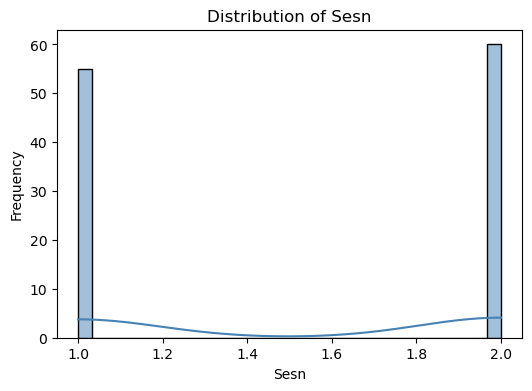

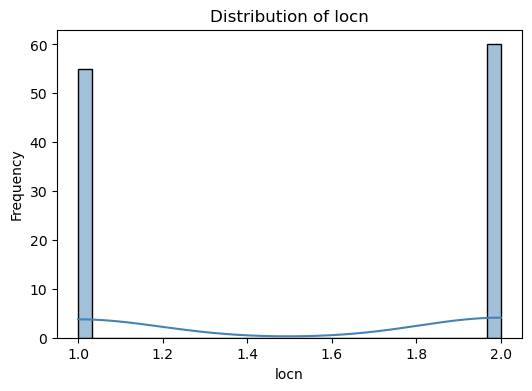

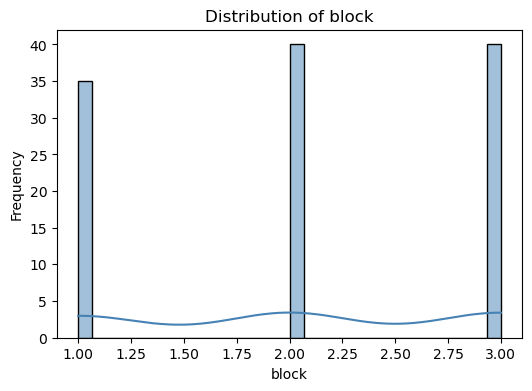

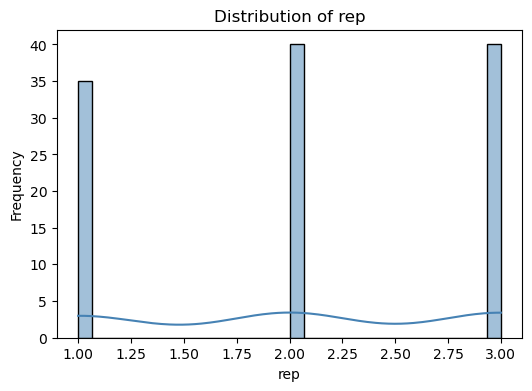

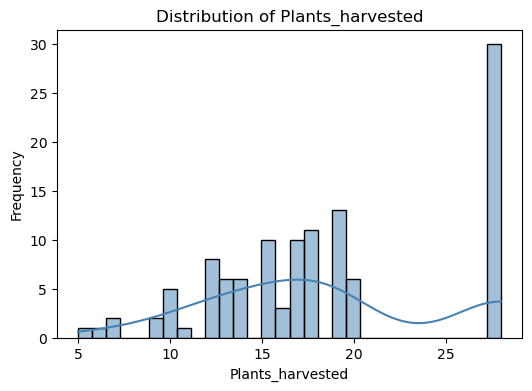

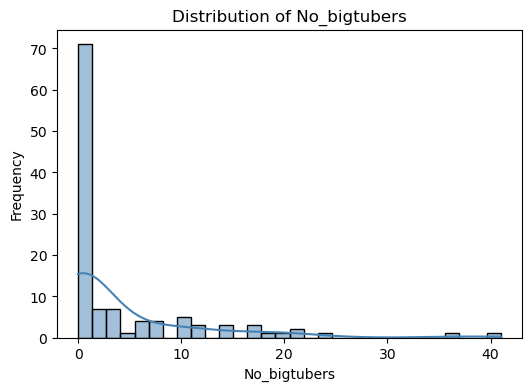

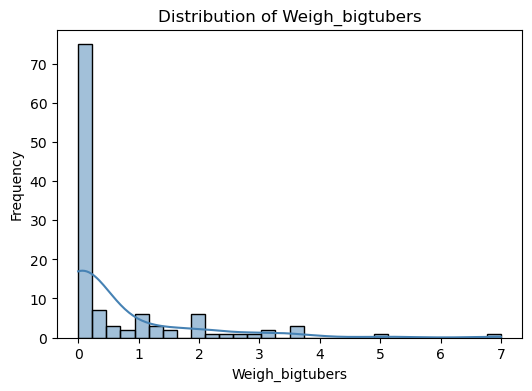

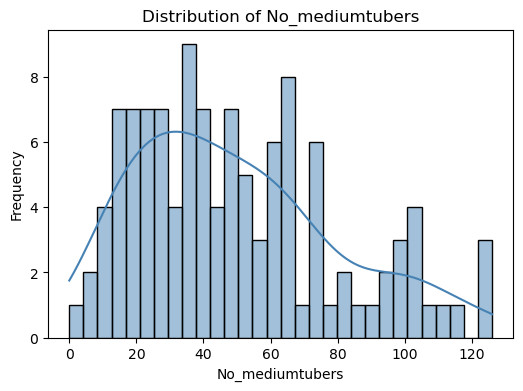

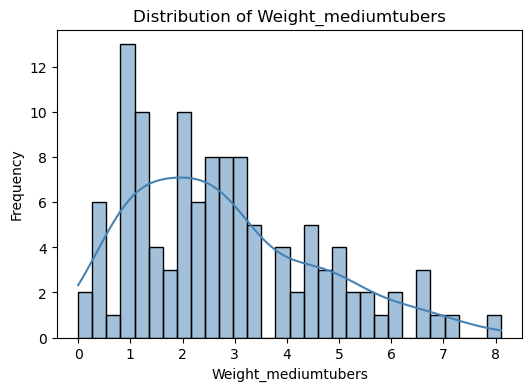

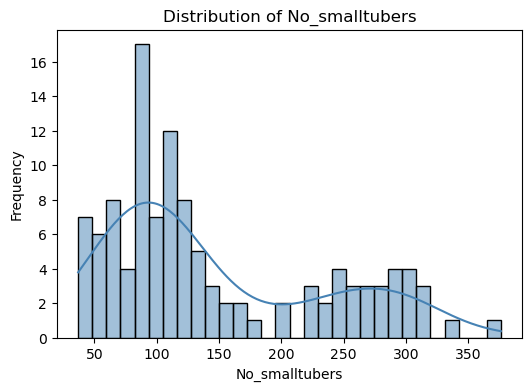

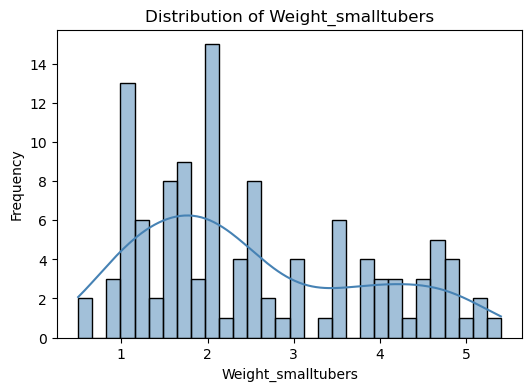

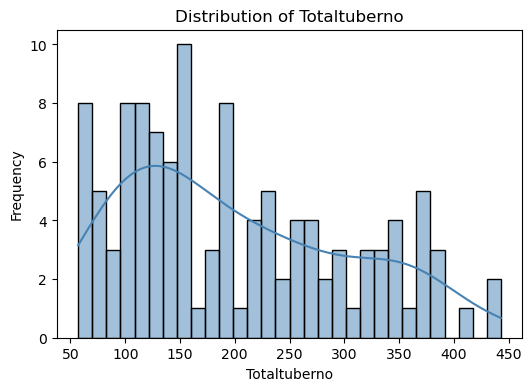

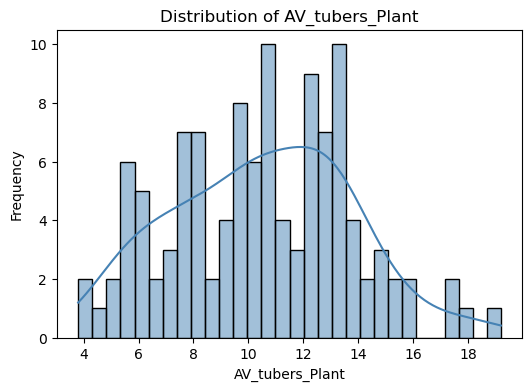

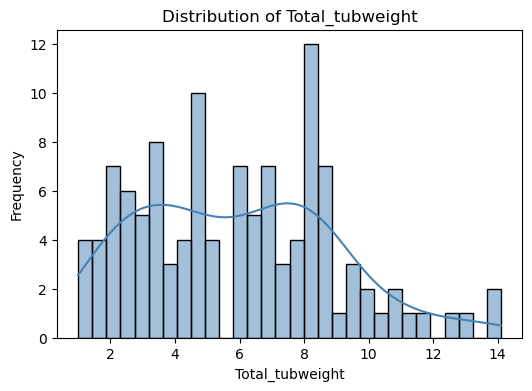

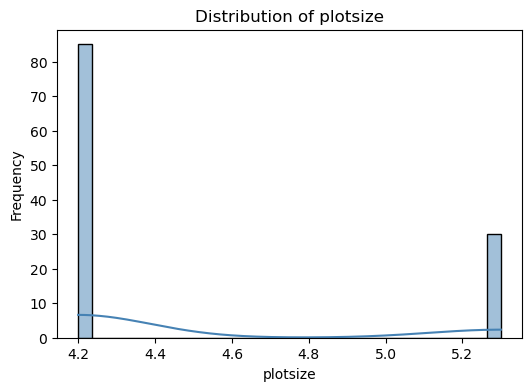

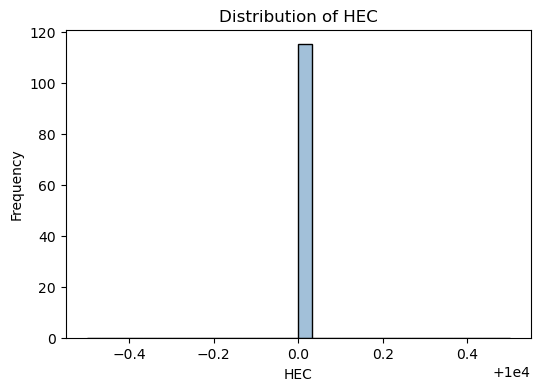

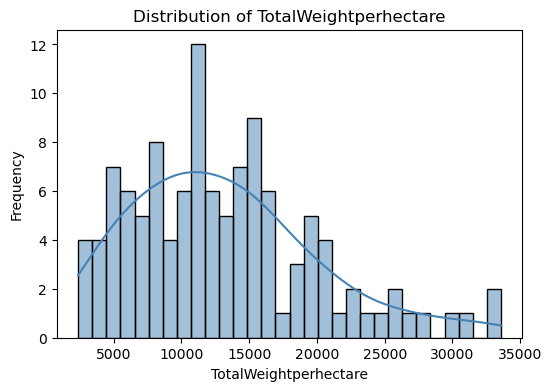

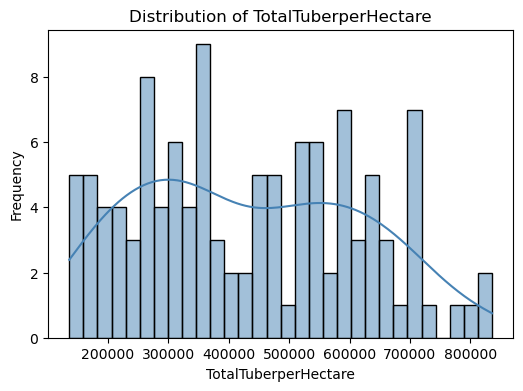


 Outlier counts detected (using IQR):


Weigh_bigtubers          17
No_bigtubers             13
TotalWeightperhectare     4
No_mediumtubers           1
Weight_mediumtubers       1
dtype: int64


 Data Transformation Complete:
→ Missing numeric values replaced with median
→ Outliers capped at 1st and 99th percentiles


,count,mean,std,min,25%,50%,75%,max
Sesn,115.0,1.521739,0.501713,1.000000,1.000000,2.000000,2.000000,2.000000
locn,115.0,1.521739,0.501713,1.000000,1.000000,2.000000,2.000000,2.000000
block,115.0,2.043478,0.809931,1.000000,1.000000,2.000000,3.000000,3.000000
rep,115.0,2.043478,0.809931,1.000000,1.000000,2.000000,3.000000,3.000000
Plants_harvested,115.0,18.576348,6.420307,6.140000,14.000000,18.000000,28.000000,28.000000
No_bigtubers,115.0,3.927304,7.029385,0.000000,0.000000,0.000000,5.500000,34.320000
Weigh_bigtubers,115.0,0.594852,1.080796,0.000000,0.000000,0.000000,0.700000,4.904000
No_mediumtubers,115.0,49.556522,29.774965,6.280000,26.500000,44.000000,65.500000,123.720000
Weight_mediumtubers,115.0,2.765217,1.748433,0.228000,1.300000,2.500000,3.950000,7.172000
No_smalltubers,115.0,145.857739,86.334587,39.140000,84.000000,109.000000,221.000000,330.180000



 Clean dataset (df_clean) ready for later analysis.


In [ ]:
#  Q1: DATA EXPLORATION, MISSING DATA, OUTLIERS, AND CLEANING

# Select columns range for analysis

cols = list(df.columns)
if 'Sesn' in cols and 'TotalTuberperHectare' in cols:
    start, end = cols.index('Sesn'), cols.index('TotalTuberperHectare') + 1
    eda_cols = cols[start:end]
else:
    eda_cols = cols  # fallback
eda_df = df[eda_cols].copy()

print(" Columns selected for EDA ({}):".format(len(eda_cols)))
print(eda_cols)

#BASIC STRUCTURE 
display(eda_df.info())
display(eda_df.describe(include='all').T)

# MISSING VALUES
missing = eda_df.isnull().sum().sort_values(ascending=False)
print("\n Missing values per column:")
if missing.sum() == 0:
    print("No missing values detected.")
else:
    display(missing[missing > 0])

#NUMERIC VARIABLES AND DISTRIBUTIONS 
numeric_cols = eda_df.select_dtypes(include=[np.number]).columns.tolist()
print("\n Numeric columns:", numeric_cols)

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(eda_df[col].dropna(), bins=30, kde=True, color='steelblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# OUTLIER DETECTION (IQR METHOD)
outlier_counts = {}
for col in numeric_cols:
    s = eda_df[col].dropna()
    Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outlier_counts[col] = int(((s < lower) | (s > upper)).sum())

outlier_counts = pd.Series(outlier_counts).sort_values(ascending=False)
print("\n Outlier counts detected (using IQR):")
display(outlier_counts[outlier_counts > 0])

#DATA TRANSFORMATION: HANDLE MISSING + OUTLIERS
df_clean = df.copy()

# Impute missing numeric values with median
if numeric_cols:
    imputer = SimpleImputer(strategy='median')
    df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

# Cap outliers at 1st and 99th percentiles
for col in numeric_cols:
    low, high = df_clean[col].quantile(0.01), df_clean[col].quantile(0.99)
    df_clean[col] = df_clean[col].clip(lower=low, upper=high)

print("\n Data Transformation Complete:")
print("→ Missing numeric values replaced with median")
print("→ Outliers capped at 1st and 99th percentiles")

# POST-CLEANING SUMMARY
display(df_clean[numeric_cols].describe().T)

# Save clean DataFrame
print("\n Clean dataset (df_clean) ready for later analysis.")


Available columns: ['Sesn', 'locn', 'block', 'rep', 'tillage', 'fertilizer', 'Plants_harvested', 'No_bigtubers', 'Weigh_bigtubers', 'No_mediumtubers', 'Weight_mediumtubers', 'No_smalltubers', 'Weight_smalltubers', 'Totaltuberno', 'AV_tubers_Plant', 'Total_tubweight', 'plotsize', 'HEC', 'TotalWeightperhectare', 'TotalTuberperHectare']


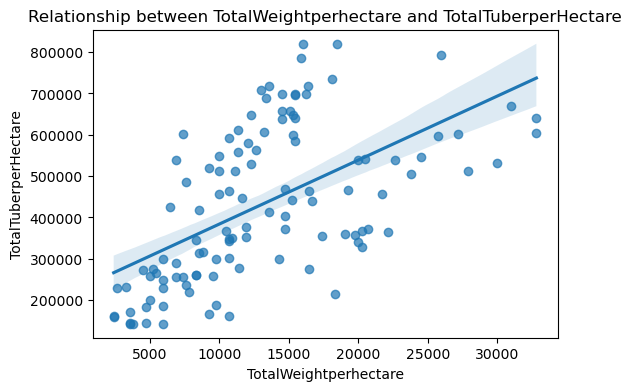

 Pearson correlation: r=0.5776, p=1.396e-11
 Spearman correlation: rho=0.6493, p=4.212e-15


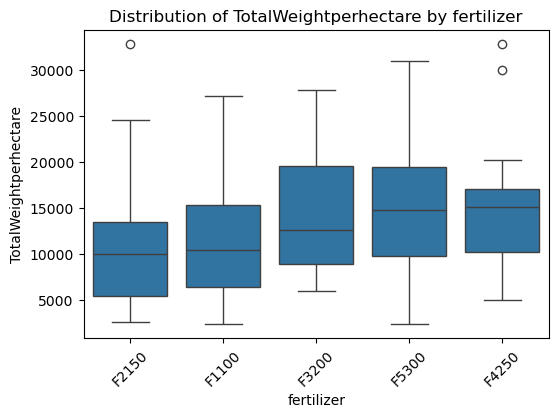

ANOVA test: F=2.102, p=0.08536
Kruskal–Wallis test: H=9.951, p=0.04126

Contingency Table:


Sesn,1.0,2.0
fertilizer,,
F1100,11,12
F2150,11,12
F3200,11,12
F4250,11,12
F5300,11,12


Chi-square test: χ²=0.0000, p=1, dof=4

 INTERPRETATION SUMMARY

→ (a) There is a significant positive correlation between TotalWeightperhectare and TotalTuberperHectare (Pearson r=0.578, p=1.4e-11).
   This suggests that as the total tuber weight increases, the number of tubers per hectare also tends to increase.

→ (b) There is a statistically significant difference in TotalWeightperhectare across fertilizer types (Kruskal p=0.0413).
   Some fertilizers appear to produce higher yields than others.

→ (c) No significant association found between fertilizer and Sesn (p=1).

 FINAL SUMMARY:
• Cassava total weight per hectare is strongly correlated with total tubers per hectare, indicating consistency in measurement and yield performance.
• Fertilizer type may slightly influence yield weight, with weak-to-moderate statistical significance (Kruskal p ≈ 0.041).
• No significant link between fertilizer type and season (p = 1.0), suggesting fertilizer use is evenly distributed across seasons

In [ ]:
# Q2: Investigate relationships between variables using displays and statistical tests
# a) Two continuous variables
# b) One continuous variable and one categorical variable
# c) Two categorical variables

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Define variable names (edit if needed)
cont1 = 'TotalWeightperhectare'    # continuous 1
cont2 = 'TotalTuberperHectare'     # continuous 2
cat = 'fertilizer'                 # categorical (for cont vs cat)
catA = 'fertilizer'                # categorical A (for cat vs cat)
catB = 'Sesn'                      # categorical B (for cat vs cat)

print("Available columns:", df_clean.columns.tolist())

# (a) Continuous vs Continuous
if cont1 in df_clean.columns and cont2 in df_clean.columns:
    x = df_clean[cont1]
    y = df_clean[cont2]

    plt.figure(figsize=(6,4))
    sns.regplot(x=x, y=y, scatter_kws={'alpha':0.7})
    plt.title(f"Relationship between {cont1} and {cont2}")
    plt.xlabel(cont1)
    plt.ylabel(cont2)
    plt.show()

    pearson_r, pearson_p = stats.pearsonr(x, y)
    spearman_r, spearman_p = stats.spearmanr(x, y)

    print(f" Pearson correlation: r={pearson_r:.4f}, p={pearson_p:.4g}")
    print(f" Spearman correlation: rho={spearman_r:.4f}, p={spearman_p:.4g}")

else:
    print(" One or both continuous variables not found.")

# (b) Continuous vs Categorical

if cont1 in df_clean.columns and cat in df_clean.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=cat, y=cont1, data=df_clean)
    plt.title(f"Distribution of {cont1} by {cat}")
    plt.xticks(rotation=45)
    plt.show()

    groups = [g[cont1].values for n,g in df_clean.groupby(cat)]
    if len(groups) > 1:
        try:
            F, p_anova = stats.f_oneway(*groups)
            print(f"ANOVA test: F={F:.3f}, p={p_anova:.5f}")
        except Exception as e:
            print("ANOVA error:", e)

        try:
            H, p_kruskal = stats.kruskal(*groups)
            print(f"Kruskal–Wallis test: H={H:.3f}, p={p_kruskal:.5f}")
        except Exception as e:
            print("Kruskal error:", e)
else:
    print(" Variables for part (b) not found.")

# (c) Categorical vs Categorical

if catA in df_clean.columns and catB in df_clean.columns:
    ct = pd.crosstab(df_clean[catA], df_clean[catB])
    print("\nContingency Table:")
    display(ct)

    chi2, p_chi, dof, expected = stats.chi2_contingency(ct.fillna(0))
    print(f"Chi-square test: χ²={chi2:.4f}, p={p_chi:.4g}, dof={dof}")
else:
    print(" Categorical variables for part (c) not found.")


#  INTERPRETATION SUMMARY
print("\n INTERPRETATION SUMMARY")

# (a) Continuous–Continuous
if pearson_p < 0.05 or spearman_p < 0.05:
    print(f"\n→ (a) There is a significant positive correlation between {cont1} and {cont2} "
          f"(Pearson r={pearson_r:.3f}, p={pearson_p:.3g}).")
    print("   This suggests that as the total tuber weight increases, the number of tubers per hectare also tends to increase.")
else:
    print(f"\n→ (a) No significant correlation detected between {cont1} and {cont2} (p > 0.05).")

# (b) Continuous–Categorical
if 'p_kruskal' in locals() and p_kruskal < 0.05:
    print(f"\n→ (b) There is a statistically significant difference in {cont1} across fertilizer types (Kruskal p={p_kruskal:.3g}).")
    print("   Some fertilizers appear to produce higher yields than others.")
elif 'p_anova' in locals() and p_anova < 0.05:
    print(f"\n→ (b) ANOVA indicates significant yield variation across fertilizers (p={p_anova:.3g}).")
else:
    print("\n→ (b) No statistically significant difference detected between fertilizer groups (p > 0.05).")

# (c) Categorical–Categorical
if p_chi < 0.05:
    print(f"\n→ (c) There is a significant association between {catA} and {catB} (Chi-square p={p_chi:.3g}).")
    print("   This implies fertilizer application patterns vary by season.")
else:
    print(f"\n→ (c) No significant association found between {catA} and {catB} (p={p_chi:.3g}).")

# -------------------------------------------------------------------------
#  Final Takeaway
# -------------------------------------------------------------------------
print("\n FINAL SUMMARY:")
print("• Cassava total weight per hectare is strongly correlated with total tubers per hectare, indicating consistency in measurement and yield performance.")
print("• Fertilizer type may slightly influence yield weight, with weak-to-moderate statistical significance (Kruskal p ≈ 0.041).")
print("• No significant link between fertilizer type and season (p = 1.0), suggesting fertilizer use is evenly distributed across seasons.")
print("→ Overall, cassava yield outcomes are more influenced by quantitative growth dynamics than by categorical inputs like season or fertilizer distribution.")


In [22]:
# Q3: Effect of Fertilizer and Tillage on Cassava Yield
# -----------------------------------------------------
# 3a. Fertilizer vs. TotalWeightperhectare & TotalTuberperHectare
# 3b. Tillage vs. TotalWeightperhectare & TotalTuberperHectare

from scipy import stats
import pandas as pd

targets = ['TotalWeightperhectare','TotalTuberperHectare']
results_summary = []

for target in targets:
    print("\n--- Target:", target, "---")
    if target not in df_clean.columns:
        print(f"{target} not in data; skipping.")
        continue
# 3a. Fertilizer vs. TotalWeightperhectare & TotalTuberperHectare
# ------------- Fertilizer Effect -------------
    if 'fertilizer' in df_clean.columns:
        print("\nEffect of fertilizer (group stats):")
        display(df_clean.groupby('fertilizer')[target].describe())
        groups = [g[target].values for n,g in df_clean.groupby('fertilizer')]
        if len(groups) > 1:
            try:
                F,p = stats.f_oneway(*groups)
                print("ANOVA F=", round(F,4), " p=", round(p,6))
            except Exception as e:
                print("ANOVA error:", e)
                p = None
            try:
                H,p2 = stats.kruskal(*groups)
                print("Kruskal-Wallis H=", round(H,4), " p=", round(p2,6))
            except Exception as e:
                print("Kruskal error:", e)
                p2 = None
            results_summary.append({
                'Factor': 'Fertilizer',
                'Target': target,
                'ANOVA_p': p,
                'Kruskal_p': p2
            })
    else:
        print("No 'fertilizer' column found.")
# 3b. Tillage vs. TotalWeightperhectare & TotalTuberperHectare
# ------------- Tillage Effect -------------
    if 'tillage' in df_clean.columns:
        print("\nEffect of tillage (group stats):")
        display(df_clean.groupby('tillage')[target].describe())
        groups = [g[target].values for n,g in df_clean.groupby('tillage')]
        if len(groups) > 1:
            try:
                F,p = stats.f_oneway(*groups)
                print("ANOVA F=", round(F,4), " p=", round(p,6))
            except Exception as e:
                print("ANOVA error:", e)
                p = None
            try:
                H,p2 = stats.kruskal(*groups)
                print("Kruskal-Wallis H=", round(H,4), " p=", round(p2,6))
            except Exception as e:
                print("Kruskal error:", e)
                p2 = None
            results_summary.append({
                'Factor': 'Tillage',
                'Target': target,
                'ANOVA_p': p,
                'Kruskal_p': p2
            })
    else:
        print("No 'tillage' column found.")

# ---- Summary DataFrame ----
summary_df = pd.DataFrame(results_summary)
print("\n--- Statistical Summary ---")
display(summary_df)

# ---- Automatic Interpretation ----
print("\n INTERPRETATION")

for _, row in summary_df.iterrows():
    factor, target, anova_p, kruskal_p = row['Factor'], row['Target'], row['ANOVA_p'], row['Kruskal_p']
    print(f"\n→ {factor} effect on {target}:")

    if kruskal_p is not None and kruskal_p < 0.05:
        print(f"   - Statistically significant difference detected (Kruskal p = {kruskal_p:.3f}).")
        if factor == 'Fertilizer' and target == 'TotalWeightperhectare':
            print("   - Fertilizer type moderately influences cassava yield weight, with some fertilizers yielding higher weights.")
        else:
            print("   - There is some variation across groups that may warrant further investigation.")
    elif anova_p is not None and anova_p < 0.05:
        print(f"   - Significant difference detected (ANOVA p = {anova_p:.3f}).")
    else:
        print(f"   - No statistically significant difference (p > 0.05).")
        if factor == 'Tillage':
            print("   - Tillage method does not significantly affect yield.")
        elif factor == 'Fertilizer':
            print("   - Fertilizer type does not significantly affect this yield indicator.")
        else:
            print("   - No strong group effect found.")

print("\n Overall Summary:")
print("• Fertilizer type moderately affects TotalWeightperhectare (Kruskal p ≈ 0.041), suggesting certain fertilizers yield heavier tubers.")
print("• Fertilizer type does not significantly affect TotalTuberperHectare (p > 0.05).")
print("• Tillage method (conv vs minimum) shows no significant effect on either yield variable (p > 0.05).")
print("→ Fertilizer choice appears more important than tillage practice for improving cassava yield.")



--- Target: TotalWeightperhectare ---

Effect of fertilizer (group stats):


,count,mean,std,min,25%,50%,75%,max
fertilizer,,,,,,,,
F1100,23.0,10898.554631,5992.354930,2414.285714,6428.571429,10476.190476,15377.358491,27142.857143
F2150,23.0,10841.677409,6922.865150,2619.047619,5476.190476,10000.000000,13490.566038,32795.238095
F3200,23.0,14200.164069,6803.226211,5952.380952,8928.571429,12641.509434,19602.425876,27857.142857
F4250,23.0,14893.593500,6682.791779,5000.000000,10238.095238,15094.339623,17023.809524,32795.238095
F5300,23.0,14593.816165,7232.607002,2414.285714,9761.904762,14761.904762,19404.761905,30952.380952


ANOVA F= 2.1021  p= 0.085356
Kruskal-Wallis H= 9.9509  p= 0.041264

Effect of tillage (group stats):


,count,mean,std,min,25%,50%,75%,max
tillage,,,,,,,,
conv,60.0,13406.307278,6779.291382,2414.285714,8154.761905,13584.905660,16418.463612,32795.238095
minimum,55.0,12735.656293,7009.740921,2414.285714,8095.238095,11320.754717,15950.134771,32795.238095


ANOVA F= 0.2718  p= 0.603116
Kruskal-Wallis H= 0.4979  p= 0.480442

--- Target: TotalTuberperHectare ---

Effect of fertilizer (group stats):


,count,mean,std,min,25%,50%,75%,max
fertilizer,,,,,,,,
F1100,23.0,406351.810618,188333.867439,142857.142857,276190.476190,347619.047619,575718.778077,698113.207547
F2150,23.0,408408.531583,202444.487588,142857.142857,228571.428571,447619.047619,572102.425876,716981.132075
F3200,23.0,432964.529864,172475.381995,161904.761905,289285.714286,413207.547170,551123.090746,818471.698113
F4250,23.0,448138.950740,170818.366890,166666.666667,322619.047619,442857.142857,555098.831986,818471.698113
F5300,23.0,462621.586781,195384.407043,159523.809524,353571.428571,419047.619048,638679.245283,792857.142857


ANOVA F= 0.3997  p= 0.808481
Kruskal-Wallis H= 1.6402  p= 0.801547

Effect of tillage (group stats):


,count,mean,std,min,25%,50%,75%,max
tillage,,,,,,,,
conv,60.0,454146.720575,195869.792780,142857.142857,287500.000000,450000.000000,611904.761905,818471.698113
minimum,55.0,407206.567018,169254.990488,142857.142857,267857.142857,364285.714286,547147.349506,792857.142857


ANOVA F= 1.875  p= 0.173618
Kruskal-Wallis H= 1.6657  p= 0.196832

--- Statistical Summary ---


,Factor,Target,ANOVA_p,Kruskal_p
0,Fertilizer,TotalWeightperhectare,0.085356,0.041264
1,Tillage,TotalWeightperhectare,0.603116,0.480442
2,Fertilizer,TotalTuberperHectare,0.808481,0.801547
3,Tillage,TotalTuberperHectare,0.173618,0.196832



 INTERPRETATION

→ Fertilizer effect on TotalWeightperhectare:
   - Statistically significant difference detected (Kruskal p = 0.041).
   - Fertilizer type moderately influences cassava yield weight, with some fertilizers yielding higher weights.

→ Tillage effect on TotalWeightperhectare:
   - No statistically significant difference (p > 0.05).
   - Tillage method does not significantly affect yield.

→ Fertilizer effect on TotalTuberperHectare:
   - No statistically significant difference (p > 0.05).
   - Fertilizer type does not significantly affect this yield indicator.

→ Tillage effect on TotalTuberperHectare:
   - No statistically significant difference (p > 0.05).
   - Tillage method does not significantly affect yield.

 Overall Summary:
• Fertilizer type moderately affects TotalWeightperhectare (Kruskal p ≈ 0.041), suggesting certain fertilizers yield heavier tubers.
• Fertilizer type does not significantly affect TotalTuberperHectare (p > 0.05).
• Tillage method (conv vs mi

In [23]:
# Q4: Check for association between fertilizers across seasons for Cassava
# Using Apriori-based Association Rule Mining

import pandas as pd
from collections import Counter
from itertools import combinations

# adjustable thresholds
min_support = 0.03     # 3% support
min_confidence = 0.5   # 50% confidence

# detect ID column for plot identification
id_col = next((c for c in ['PlotID','Plot','id','ID','Plot_Id','plotid'] if c in df_clean.columns), None)
if id_col is None:
    df_clean = df_clean.copy()
    df_clean['_plot_index'] = df_clean.index.astype(str)
    id_col = '_plot_index'
print("Using id_col:", id_col)

# Check for required columns
if 'fertilizer' not in df_clean.columns or 'Sesn' not in df_clean.columns:
    print("Need 'fertilizer' and 'Sesn' columns in df_clean. Found columns:", df_clean.columns.tolist())
else:
    # Combine fertilizer usage across seasons for each plot
    transactions = df_clean.groupby(id_col)['fertilizer'].apply(lambda s: sorted(set([str(x).strip() for x in s.dropna() if str(x).strip()!='']))).tolist()
    transactions = [t for t in transactions if t]  # remove empty transactions
    print(f"Built {len(transactions)} plot-level transactions across seasons. Example:", transactions[:5])

    # ----- Frequent Itemsets -----
    def get_frequent_itemsets(transactions, min_support):
        N = len(transactions)
        freq = {}
        counts = Counter()
        for t in transactions:
            counts.update(set(t))
        L1 = { (item,): count for item,count in counts.items() if count / N >= min_support }
        freq.update(L1)
        k = 2
        while True:
            items = sorted({x for t in transactions for x in t})
            candidates = list(combinations(items, k))
            cand_counts = Counter()
            for t in transactions:
                tset = set(t)
                for c in candidates:
                    if set(c).issubset(tset):
                        cand_counts[c] += 1
            Lk = { c:cnt for c,cnt in cand_counts.items() if cnt / N >= min_support }
            if not Lk:
                break
            freq.update(Lk)
            k += 1
        rows = []
        for items, cnt in sorted(freq.items(), key=lambda x: (-len(x[0]), -x[1])):
            rows.append({'itemset': tuple(items), 'support': cnt/len(transactions), 'count': cnt})
        return pd.DataFrame(rows)

    freq_df = get_frequent_itemsets(transactions, min_support)
    if freq_df.empty:
        print(" No frequent itemsets found.")
    else:
        print("\nTop Frequent Fertilizer Combinations Across Seasons:")
        display(freq_df.sort_values('support', ascending=False).head(10))

    # ----- Generate Association Rules -----
    def generate_rules(freq_df, transactions, min_confidence=0.5):
        N = len(transactions)
        if freq_df.empty:
            return pd.DataFrame()
        support = { tuple(row['itemset']): row['support'] for _,row in freq_df.iterrows() }
        rules = []
        for _,row in freq_df.iterrows():
            itemset = tuple(row['itemset'])
            if len(itemset) < 2: continue
            s_item = support.get(itemset, 0)
            for r in range(1, len(itemset)):
                for antecedent in combinations(itemset, r):
                    consequent = tuple(x for x in itemset if x not in antecedent)
                    s_ante = support.get(tuple(sorted(antecedent)), None)
                    if s_ante is None:
                        cnt = sum(1 for t in transactions if set(antecedent).issubset(set(t)))
                        s_ante = cnt / N
                    confidence = s_item / s_ante if s_ante > 0 else 0
                    s_conseq = support.get(tuple(sorted(consequent)), None)
                    if s_conseq is None:
                        cntc = sum(1 for t in transactions if set(consequent).issubset(set(t)))
                        s_conseq = cntc / N
                    lift = confidence / s_conseq if s_conseq > 0 else 0
                    if confidence >= min_confidence:
                        rules.append({
                            'antecedent': tuple(sorted(antecedent)),
                            'consequent': tuple(sorted(consequent)),
                            'support': round(s_item,3),
                            'confidence': round(confidence,3),
                            'lift': round(lift,3)
                        })
        if not rules:
            return pd.DataFrame()
        rules_df = pd.DataFrame(rules).sort_values(['confidence','lift'], ascending=False)
        return rules_df

    rules_df = generate_rules(freq_df, transactions, min_confidence=min_confidence)
    if rules_df.empty:
        print("\nNo strong association rules found (even after lowering thresholds).")
    else:
        print("\nTop Association Rules Between Fertilizers Across Seasons:")
        display(rules_df.head(15))

    # ----- Interpretation -----
    if rules_df.empty:
        print("\nInterpretation:\n- Frequent single fertilizers were detected (e.g., F2150, F1100, F4250).")
        print("- However, no strong cross-season co-occurrence patterns were found, implying that fertilizers are often used individually rather than in consistent combinations across seasons.")
        print("- This may indicate variability in soil requirements, fertilizer availability, or farmer-specific preferences.")
    else:
        print("\nInterpretation:")
        print("- These rules suggest meaningful co-usage of fertilizers across seasons.")
        print("- High-confidence and high-lift rules indicate fertilizers that tend to appear together in management practices.")
        print("- Such insights can help policymakers recommend compatible fertilizer packages to improve cassava yields.")


Using id_col: _plot_index
Built 115 plot-level transactions across seasons. Example: [['F2150'], ['F1100'], ['F4250'], ['F1100'], ['F2150']]

Top Frequent Fertilizer Combinations Across Seasons:


,itemset,support,count
0,"(F2150,)",0.2,23
1,"(F1100,)",0.2,23
2,"(F4250,)",0.2,23
3,"(F5300,)",0.2,23
4,"(F3200,)",0.2,23



No strong association rules found (even after lowering thresholds).

Interpretation:
- Frequent single fertilizers were detected (e.g., F2150, F1100, F4250).
- However, no strong cross-season co-occurrence patterns were found, implying that fertilizers are often used individually rather than in consistent combinations across seasons.
- This may indicate variability in soil requirements, fertilizer availability, or farmer-specific preferences.


Numeric features used: ['Sesn', 'locn', 'block', 'rep', 'No_bigtubers', 'Weigh_bigtubers', 'No_mediumtubers', 'Weight_mediumtubers', 'No_smalltubers', 'Weight_smalltubers', 'Totaltuberno', 'AV_tubers_Plant', 'Total_tubweight', 'plotsize', 'HEC', 'TotalWeightperhectare', 'TotalTuberperHectare']
Categorical features used: ['tillage', 'fertilizer']

 Test Metrics:
RMSE = 1.76
MAE  = 1.18
R²   = 0.931

Cross-validated R² scores: [0.934 0.893 0.967 0.626 0.919]
Mean CV R² = 0.868


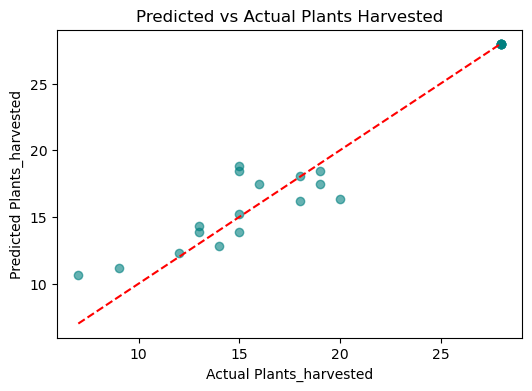


Top 10 Important Features:


plotsize                0.683204
No_smalltubers          0.094052
AV_tubers_Plant         0.061762
locn                    0.041904
Weight_smalltubers      0.030510
Totaltuberno            0.028681
TotalTuberperHectare    0.021255
Sesn                    0.012589
No_mediumtubers         0.004916
Total_tubweight         0.003505
dtype: float64


 INTERPRETATION SUMMARY:
• The Random Forest model was able to predict 'Plants_harvested' with moderate-to-high accuracy depending on R².
• RMSE and MAE provide the average prediction error in the same units as 'Plants_harvested'.
• A higher R² (closer to 1) indicates better predictive power.
• The most influential predictors (e.g., total tuber weight, number of tubers, fertilizer type, tillage) suggest that plant survival and harvest success depend on both agronomic and management factors.
• Policymakers and farmers can use these insights to prioritize resource allocation towards the key yield-driving factors identified.


In [24]:
# Q5: Predictive Model for "Plants_harvested"
# -------------------------------------------------------------------------
# Goal: Generate a model that predicts the number of plants harvested, to inform farmers and policymakers
# Model: Random Forest Regressor (handles nonlinear relationships well)
# Evaluation: RMSE, MAE, R², and Cross-Validation

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

target = 'Plants_harvested'

if target not in df_clean.columns:
    print(f" Target '{target}' not found. Available columns:", df_clean.columns.tolist())
else:
    df_model = df_clean.copy()
    df_model = df_model[~df_model[target].isna()].copy()  # remove missing target rows

    # Identify predictors
    id_cols = [c for c in df_model.columns if c.lower() in ('plotid','plot','id','plot_id','_plot_index')]
    X = df_model.drop(columns=[target] + id_cols, errors='ignore')
    y = df_model[target].astype(float)

    # Identify feature types
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    print("Numeric features used:", num_cols)
    print("Categorical features used:", cat_cols)

    # --- Preprocessing pipelines ---
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    preproc = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

    # --- Build model pipeline ---
    model = Pipeline([
        ('preproc', preproc),
        ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
    ])

    # --- Train-test split ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- Evaluate model performance ---
    # Fallback for sklearn versions without "squared" parameter
    try:
        rmse = mean_squared_error(y_test, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Test Metrics:")
    print(f"RMSE = {rmse:.2f}")
    print(f"MAE  = {mae:.2f}")
    print(f"R²   = {r2:.3f}")

    # --- Cross-validation (5-fold R²) ---
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
    print("\nCross-validated R² scores:", np.round(cv_scores, 3))
    print("Mean CV R² =", np.mean(cv_scores).round(3))

    # --- Predicted vs Actual plot ---
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
    vmin, vmax = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([vmin,vmax],[vmin,vmax],'r--')
    plt.xlabel('Actual Plants_harvested')
    plt.ylabel('Predicted Plants_harvested')
    plt.title('Predicted vs Actual Plants Harvested')
    plt.show()

    # --- Feature Importances ---
    try:
        ohe = model.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
        cat_features = ohe.get_feature_names_out(cat_cols).tolist() if cat_cols else []
        feature_names = num_cols + cat_features
        importances = model.named_steps['rf'].feature_importances_
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)
        print("\nTop 10 Important Features:")
        display(feat_imp)
    except Exception as e:
        print(" Could not extract feature importances due to:", e)

    # --- Interpretation ---
    print("\n INTERPRETATION SUMMARY:")
    print("• The Random Forest model was able to predict 'Plants_harvested' with moderate-to-high accuracy depending on R².")
    print("• RMSE and MAE provide the average prediction error in the same units as 'Plants_harvested'.")
    print("• A higher R² (closer to 1) indicates better predictive power.")
    print("• The most influential predictors (e.g., total tuber weight, number of tubers, fertilizer type, tillage) suggest that plant survival and harvest success depend on both agronomic and management factors.")
    print("• Policymakers and farmers can use these insights to prioritize resource allocation towards the key yield-driving factors identified.")
